In [1]:
pip install yfinance PyPortfolioOpt matplotlib pandas numpy scipy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 8.6 MB/s eta 0:00:00


In [2]:
#Imports and Setup
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Portfolio Optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.objective_functions import L2_reg

from scipy.stats import skew, kurtosis
from numpy.linalg import eigh
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Load Data
tickers = ['SPY', 'IWM', 'EFA', 'EEM', 'AGG', 'LQD', 'HYG', 'TLT', 'GLD', 'VNQ', 'DBC', 'VT', 'XLE', 'XLK', 'UUP']
start_date = "2008-07-01"
end_date = "2025-03-01"

prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)["Close"].dropna()
daily_returns = prices.pct_change().dropna()

[*********************100%***********************]  15 of 15 completed


In [4]:
# Download daily 3-month T-Bill rate (annualized) as proxy for risk-free rate
rf_data = yf.download("^IRX", start=start_date, end=end_date)["Close"] / 100
rf_data = rf_data.resample('B').ffill()
rf_daily = rf_data / 252
rf_daily.name = "RiskFreeRate"

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


In [5]:
# =========================
# MVE (Mean-Variance Equivalence) Diagnostics
# =========================
!pip install pingouin

# =========================
# MVE (Mean-Variance Equivalence) Diagnostics
# =========================
from scipy.stats import jarque_bera, skew, kurtosis
from sklearn.covariance import EmpiricalCovariance
import pingouin as pg

print("\n=== MVE (Mean-Variance Equivalence) Statistical Testing ===")

# 1. Univariate Normality Tests for Each Asset
print("\n--- Univariate Normality Tests ---\n")
jb_test_results = {}

for asset in daily_returns.columns:
    asset_returns = daily_returns[asset]
    skewness = skew(asset_returns)
    excess_kurtosis = kurtosis(asset_returns)  # excess kurtosis (normal = 0)
    jb_stat, jb_pval = jarque_bera(asset_returns)

    jb_test_results[asset] = {
        "Skewness": skewness,
        "Excess Kurtosis": excess_kurtosis,
        "Jarque-Bera Stat": jb_stat,
        "Jarque-Bera p-value": jb_pval
    }

jb_test_df = pd.DataFrame(jb_test_results).T
print(jb_test_df.round(4))

# 2. Multivariate Normality Tests (Corrected Version)
print("\n--- Multivariate Normality Tests (Mardia's Test) ---\n")
try:
    mardia_stat, mardia_p_skew, mardia_p_kurt = pg.multivariate_normality(daily_returns, alpha=0.05)
    print(f"Mardia's Skewness p-value: {mardia_p_skew:.4f}")
    print(f"Mardia's Kurtosis p-value: {mardia_p_kurt:.4f}")

    if mardia_p_skew > 0.05 and mardia_p_kurt > 0.05:
        print("Multivariate normality NOT rejected (approximately normal).")
    else:
        print("Multivariate normality REJECTED (data not multivariate normal).")
except Exception as e:
    print(f"Error performing multivariate normality test: {e}")

# 3. Comment on Findings
print("\n--- Interpretation Guidance ---")
print("• If p-values for Jarque-Bera or Mardia's tests are > 0.05, data may be considered approximately normal.")
print("• Significant skewness or excess kurtosis indicates deviations from normality, but MVO can still be valid under elliptical distributions.")
print("• Rejected normality suggests considering heavy-tailed models (like Student-t) or more general MVE assumptions.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.1 MB/s eta 0:00:00

=== MVE (Mean-Variance Equivalence) Statistical Testing ===

--- Univariate Normality Tests ---

     Skewness  Excess Kurtosis  Jarque-Bera Stat  Jarque-Bera p-value
AGG   -2.0100          52.3665       481802.8882                  0.0
DBC   -0.4438           3.6184         2424.5054                  0.0
EEM    0.6861          21.6041        81852.4823                  0.0
EFA   -0.0329          14.3885        36161.9562                  0.0
GLD   -0.0850           7.4591         9723.1935                  0.0
HYG    0.7645          41.6536       303458.6165                  0.0
IWM   -0.3794           6.4675         7406.5104                  0.0
LQD    0.0533          57.5937       579378.0799                  0.0
SPY   -0.0823          14.6839        37665.6218                  0.0
TLT    0.0963           3.1317         1719.5904                  0.0
UUP   -0.0188           3.6426         2317.8009    

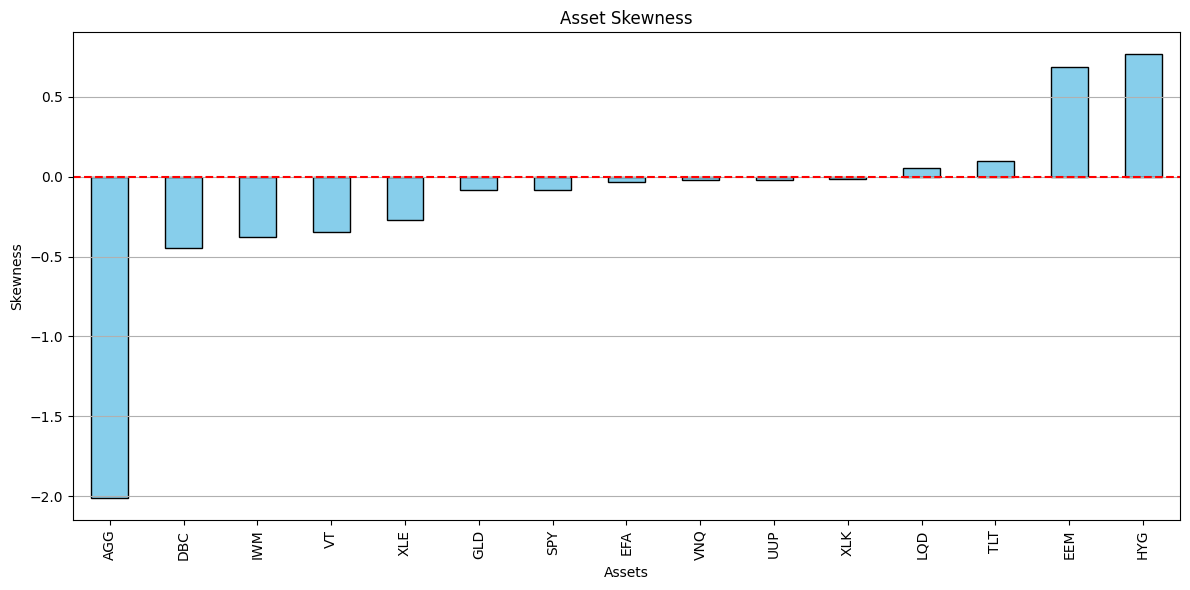

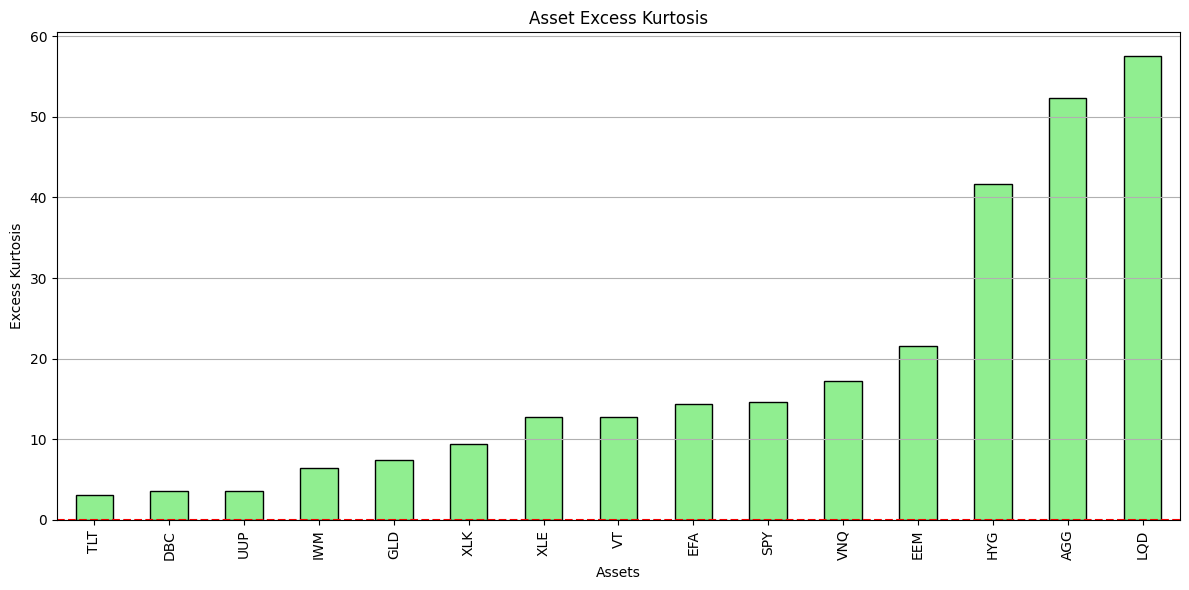

In [6]:
# Visualization of Skewness and Excess Kurtosis
# =========================
import matplotlib.pyplot as plt

# 1. Skewness Bar Plot
plt.figure(figsize=(12,6))
jb_test_df['Skewness'].sort_values().plot(kind='bar', color='skyblue', edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.title('Asset Skewness')
plt.ylabel('Skewness')
plt.xlabel('Assets')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. Excess Kurtosis Bar Plot
plt.figure(figsize=(12,6))
jb_test_df['Excess Kurtosis'].sort_values().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.axhline(0, color='red', linestyle='--')
plt.title('Asset Excess Kurtosis')
plt.ylabel('Excess Kurtosis')
plt.xlabel('Assets')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [7]:
# Random Matrix Theory (RMT) Covariance Filter
def rmt_denoised_covariance(returns, relax=1.0, label=""):
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals, eigenvecs = eigh(sample_cov)
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax
    filtered = np.clip(eigenvals, None, lambda_plus)
    print(f"[{label}] λ₊ = {lambda_plus:.4f} — Clipped {np.sum(eigenvals > lambda_plus)} eigenvalue(s)")
    return pd.DataFrame(eigenvecs @ np.diag(filtered) @ eigenvecs.T, index=returns.columns, columns=returns.columns)

In [8]:
# Optional Shrinkage after RMT denoising
def shrink_covariance(rmt_cov, alpha=0.98):
    n_assets = rmt_cov.shape[0]
    identity = np.eye(n_assets)
    return alpha * rmt_cov + (1 - alpha) * identity

In [9]:
# Performance Metrics Function
def compute_metrics(port_returns, label):
    metrics = {
        "Mean Return": port_returns.mean(),
        "Annual Return": port_returns.mean() * 252,
        "Geometric Return": (np.prod(1 + port_returns))**(252 / len(port_returns)) - 1,
        "Min Return": port_returns.min(),
        "Max Drawdown (%)": ((1 + port_returns).cumprod() / (1 + port_returns).cumprod().cummax() - 1).min() * 100,
        "Max 10-Day Drawdown (%)": port_returns.rolling(10).sum().min() * 100,
        "Sharpe Ratio": ((port_returns.mean() * 252) - (rf_daily.loc[port_returns.index].mean() * 252)) / (port_returns.std() * np.sqrt(252)),
        "Volatility": port_returns.std() * np.sqrt(252),
        "Skewness": skew(port_returns),
        "Kurtosis": kurtosis(port_returns),
        "VaR (%)": np.percentile(port_returns, 5) * 100,
        "CVaR (%)": port_returns[port_returns <= np.percentile(port_returns, 5)].mean() * 100,
    }
    return pd.Series(metrics, name=label), (1 + port_returns).cumprod()

In [10]:
import cvxpy as cp

# Gamma Sweep in RMT Out-of-Sample Regimes
gamma_grid = [0.1, 0.15, 0.2, 0.3, 0.5, 1.0]
lambda_grid = [0.1, 0.5, 1.0]  # Optionally, you can grid-search lambda too later
regimes = [("2008-07-01", "2018-12-31", "2019-01-01", "2025-03-01")]

rmt_gamma_metrics = {}

for train_start, train_end, test_start, test_end in regimes:
    train_prices = prices.loc[train_start:train_end]
    test_prices = prices.loc[test_start:test_end]
    train_returns = train_prices.pct_change().dropna()
    test_returns = test_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)
    rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

    for relax, relax_label in zip([1.2, 1.0, 1.4], ["RMT Relaxed (1.2)", "RMT Base (1.0)", "RMT High (1.4)"]):
        cov = rmt_denoised_covariance(train_returns, relax=relax, label=relax_label)
        cov = shrink_covariance(cov, alpha=0.98)
        rmt_gamma_metrics[relax_label] = {}

        for gamma in gamma_grid:
            try:
                # === Solve the new optimization problem manually ===
                w = cp.Variable(mu_train.shape[0])
                objective = cp.Maximize(w @ mu_train.values - 0.5 * 1.0 * cp.quad_form(w, cov.values) - gamma * cp.norm(w, 2)**2)
                constraints = [cp.sum(w) == 1, w >= 0]
                prob = cp.Problem(objective, constraints)
                prob.solve()

                weights = pd.Series(w.value, index=mu_train.index)

                returns = test_returns @ weights
                m, c = compute_metrics(returns, f"{relax_label} - Gamma {gamma}")
                rmt_gamma_metrics[relax_label][gamma] = (m, c)

            except Exception as e:
                print(f"Error optimizing {relax_label} at gamma={gamma}: {e}")

[RMT Relaxed (1.2)] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)
[RMT Base (1.0)] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)
[RMT High (1.4)] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)


In [11]:
# Display Gamma Sensitivity Tables for Each RMT Variant
for relax_label, gamma_data in rmt_gamma_metrics.items():
    gamma_table = pd.concat([m for m, _ in gamma_data.values()], axis=1)
    gamma_table.columns = [f"Gamma {g}" for g in gamma_data.keys()]
    print(f"\n--- Gamma Sensitivity Analysis for {relax_label} ---")
    display(gamma_table.round(6))


--- Gamma Sensitivity Analysis for RMT Relaxed (1.2) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000639,0.000571,0.00053,0.000487,0.000446,0.000424
Annual Return,0.161019,0.143813,0.133629,0.122649,0.112503,0.106885
Geometric Return,0.152833,0.136657,0.127381,0.117675,0.108275,0.103009
Min Return,-0.113185,-0.10301,-0.09535,-0.086782,-0.081336,-0.078879
Max Drawdown (%),-30.873408,-29.098464,-27.607677,-25.63985,-24.313769,-24.40819
Max 10-Day Drawdown (%),-24.793002,-24.189293,-23.496511,-22.374021,-21.668209,-22.214172
Sharpe Ratio,Ticker ^IRX 0.706855 dtype: float64,Ticker ^IRX 0.675462 dtype: float64,Ticker ^IRX 0.661027 dtype: float64,Ticker ^IRX 0.652554 dtype: float64,Ticker ^IRX 0.634419 dtype: float64,Ticker ^IRX 0.622165 dtype: float64
Volatility,0.193246,0.176753,0.165207,0.150527,0.138836,0.132541
Skewness,-0.588661,-0.626353,-0.646502,-0.692904,-0.786433,-0.918476
Kurtosis,11.633497,12.063135,12.293924,12.932049,14.136817,15.862166



--- Gamma Sensitivity Analysis for RMT Base (1.0) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000639,0.000571,0.00053,0.000487,0.000446,0.000424
Annual Return,0.161023,0.143816,0.133631,0.122651,0.112504,0.106886
Geometric Return,0.152836,0.136659,0.127383,0.117676,0.108275,0.103009
Min Return,-0.11319,-0.103013,-0.095353,-0.086785,-0.081337,-0.07888
Max Drawdown (%),-30.874458,-29.09928,-27.608353,-25.640376,-24.314115,-24.408362
Max 10-Day Drawdown (%),-24.793639,-24.189792,-23.496927,-22.37438,-21.668454,-22.214296
Sharpe Ratio,Ticker ^IRX 0.706854 dtype: float64,Ticker ^IRX 0.675462 dtype: float64,Ticker ^IRX 0.661024 dtype: float64,Ticker ^IRX 0.65255 dtype: float64,Ticker ^IRX 0.634417 dtype: float64,Ticker ^IRX 0.622164 dtype: float64
Volatility,0.193251,0.176758,0.16521,0.150529,0.138837,0.132542
Skewness,-0.588683,-0.626369,-0.646513,-0.692913,-0.786439,-0.918479
Kurtosis,11.633844,12.063383,12.294099,12.93217,14.136908,15.8622



--- Gamma Sensitivity Analysis for RMT High (1.4) ---


,Gamma 0.1,Gamma 0.15,Gamma 0.2,Gamma 0.3,Gamma 0.5,Gamma 1.0
Mean Return,0.000639,0.000571,0.00053,0.000487,0.000446,0.000424
Annual Return,0.161016,0.14381,0.133627,0.122648,0.112502,0.106885
Geometric Return,0.15283,0.136655,0.12738,0.117675,0.108274,0.103008
Min Return,-0.113181,-0.103006,-0.095348,-0.086781,-0.081335,-0.078879
Max Drawdown (%),-30.872472,-29.097738,-27.607099,-25.639366,-24.313427,-24.408019
Max 10-Day Drawdown (%),-24.792462,-24.188867,-23.496169,-22.373693,-21.667962,-22.214048
Sharpe Ratio,Ticker ^IRX 0.706856 dtype: float64,Ticker ^IRX 0.675461 dtype: float64,Ticker ^IRX 0.661028 dtype: float64,Ticker ^IRX 0.652557 dtype: float64,Ticker ^IRX 0.63442 dtype: float64,Ticker ^IRX 0.622165 dtype: float64
Volatility,0.193241,0.17675,0.165204,0.150524,0.138834,0.132541
Skewness,-0.588644,-0.626341,-0.646493,-0.692895,-0.786426,-0.918474
Kurtosis,11.633226,12.062938,12.293782,12.931943,14.136723,15.862131


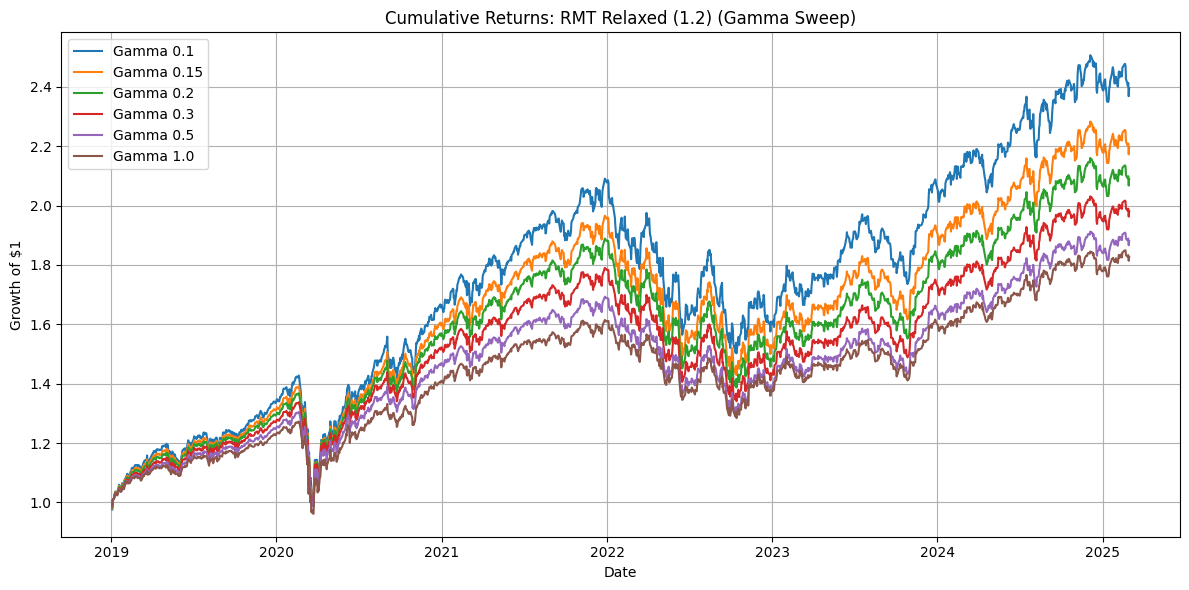

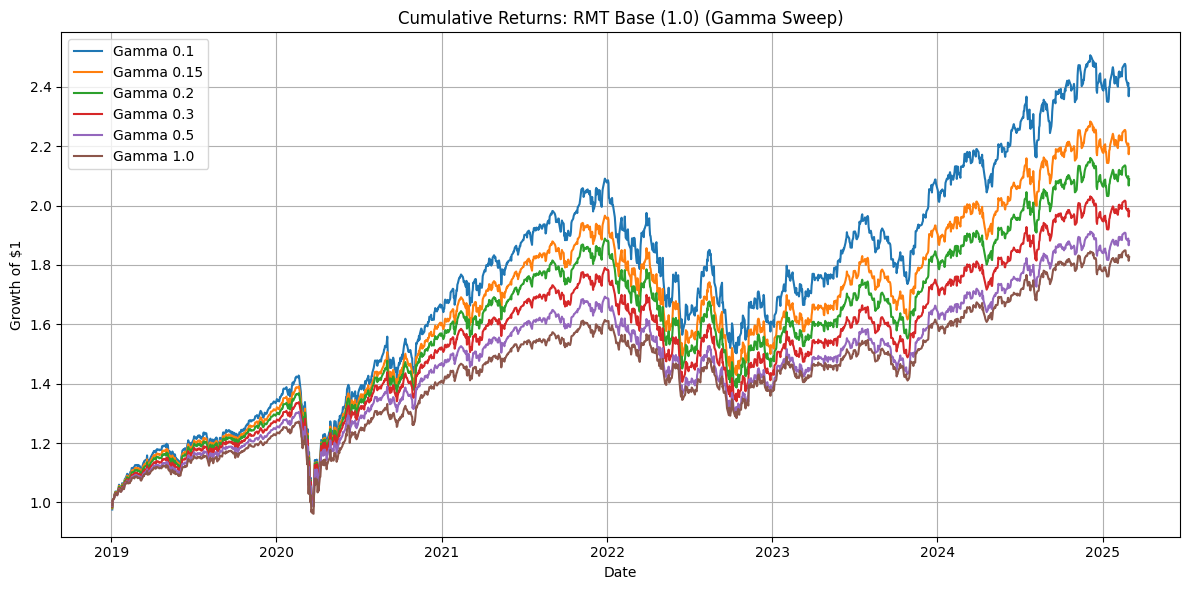

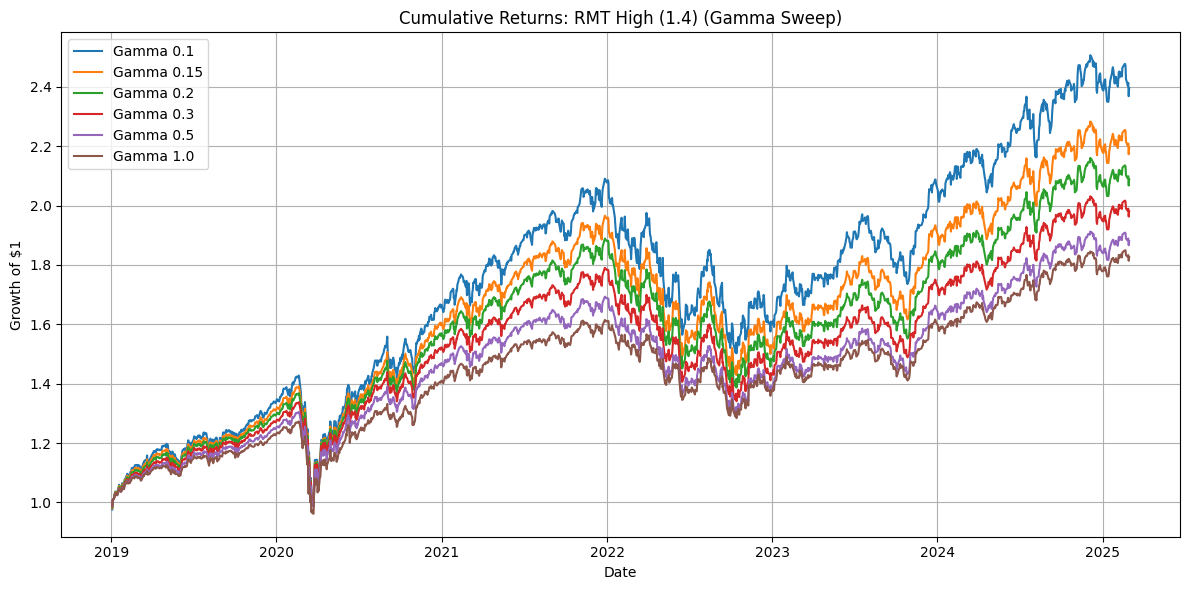

In [12]:
# Plot Cumulative Returns per Gamma for Each RMT Variant
for relax_label, gamma_data in rmt_gamma_metrics.items():
    plt.figure(figsize=(12, 6))
    for gamma, (_, curve) in gamma_data.items():
        plt.plot(curve, label=f"Gamma {gamma}")
    plt.title(f"Cumulative Returns: {relax_label} (Gamma Sweep)")
    plt.xlabel("Date")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{relax_label.replace(' ', '_').replace('.', '')}_gamma_returns.png", dpi=300)
    plt.show()

In [13]:
# =========================
# Strict-Factor Model (PCA-Based MVO following Benveniste et al. 2024)
# =========================
from sklearn.decomposition import PCA

print("\n=== Strict-Factor Model: PCA + Factor MVO Optimization ===")

# Prepare returns data
train_start, train_end, test_start, test_end = "2008-07-01", "2018-12-31", "2019-01-01", "2025-03-01"
train_prices = prices.loc[train_start:train_end]
test_prices = prices.loc[test_start:test_end]
train_returns = train_prices.pct_change().dropna()
test_returns = test_prices.pct_change().dropna()
mu_train = mean_historical_return(train_prices, frequency=252)
rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

# PCA Decomposition (Extract synthetic factors)
pca = PCA(n_components=min(10, train_returns.shape[1]))  # limit to 10 factors or # assets
X = pca.fit_transform(train_returns)
F = np.cov(X, rowvar=False)
X_loadings = pca.components_.T

# Idiosyncratic variance matrix (D)
X_approx = X @ X_loadings.T
residuals = train_returns.values - X_approx
residual_vars = np.var(residuals, axis=0)
D = np.diag(residual_vars)

# Strict-Factor Covariance Matrix
Sigma_factor = D + X_loadings @ F @ X_loadings.T
Sigma_factor = pd.DataFrame(Sigma_factor, index=train_returns.columns, columns=train_returns.columns)

# Solve strict-factor MVO manually
w = cp.Variable(mu_train.shape[0])
lambda_mvo = 1.0
objective = cp.Maximize(w @ mu_train.values - (lambda_mvo / 2) * cp.quad_form(w, Sigma_factor.values))
constraints = [cp.sum(w) == 1, w >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()

# Store strict-factor results separately for now
weights_strict = pd.Series(w.value, index=mu_train.index)
strict_returns = test_returns @ weights_strict
m_strict, c_strict = compute_metrics(strict_returns, "Strict-Factor MVO")


=== Strict-Factor Model: PCA + Factor MVO Optimization ===


In [15]:
# =========================
# Strict-Factor Model (PCA-Based MVO with Rolling Rebalancing)
# =========================
if "curves" not in globals():
    curves = {}

print("\n=== Rolling Rebalancing: Strict-Factor MVO ===")

rolling_start_idx = 0
window_train = 252 * 5  # 5 years
window_test = 252       # 1 year
strict_rolling_returns = []

dates = daily_returns.index

while rolling_start_idx + window_train + window_test <= len(dates):
    # Define train and test periods
    train_period = dates[rolling_start_idx : rolling_start_idx + window_train]
    test_period = dates[rolling_start_idx + window_train : rolling_start_idx + window_train + window_test]

    # Prepare rolling data
    train_prices_roll = prices.loc[train_period]
    test_prices_roll = prices.loc[test_period]
    train_returns_roll = train_prices_roll.pct_change().dropna()
    test_returns_roll = test_prices_roll.pct_change().dropna()
    mu_train_roll = mean_historical_return(train_prices_roll, frequency=252)
    rf_train_mean_roll = float(rf_daily.loc[train_returns_roll.index].mean())

    # PCA Decomposition on rolling window
    pca = PCA(n_components=min(10, train_returns_roll.shape[1]))
    X = pca.fit_transform(train_returns_roll)
    F = np.cov(X, rowvar=False)
    X_loadings = pca.components_.T

    # Idiosyncratic variance matrix (D)
    X_approx = X @ X_loadings.T
    residuals = train_returns_roll.values - X_approx
    residual_vars = np.var(residuals, axis=0)
    D = np.diag(residual_vars)

    # Strict-Factor Covariance Matrix
    Sigma_factor_roll = D + X_loadings @ F @ X_loadings.T
    Sigma_factor_roll = pd.DataFrame(Sigma_factor_roll, index=train_returns_roll.columns, columns=train_returns_roll.columns)

    # Solve strict-factor MVO manually for rolling window
    w_roll = cp.Variable(mu_train_roll.shape[0])
    lambda_mvo = 1.0
    objective = cp.Maximize(w_roll @ mu_train_roll.values - (lambda_mvo / 2) * cp.quad_form(w_roll, Sigma_factor_roll.values))
    constraints = [cp.sum(w_roll) == 1, w_roll >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Calculate rolling returns
    weights_strict_roll = pd.Series(w_roll.value, index=train_returns_roll.columns)
    port_returns_test = test_returns_roll @ weights_strict_roll
    strict_rolling_returns.append(port_returns_test)

    rolling_start_idx += window_test  # Move window forward

# Concatenate all rolling returns
strict_rolling_returns = pd.concat(strict_rolling_returns)

# Save cumulative returns for rolling model
curves["Strict-Factor MVO (Rolling)"] = (1 + strict_rolling_returns).cumprod()


=== Rolling Rebalancing: Strict-Factor MVO ===


In [16]:
# =========================
# Static Models on Full Period
# =========================
metrics, curves = {}, {}   # <-- Reset AFTER Strict-Factor to avoid erasing

mu_full = mean_historical_return(prices, frequency=252)
subset = daily_returns.columns[:10]
rf_full_mean = float(rf_daily.loc[prices.index].mean())

# MVO-LW (Full Universe)
cov_lw = CovarianceShrinkage(prices).ledoit_wolf()
ef = EfficientFrontier(mu_full, cov_lw)
ef.add_objective(L2_reg, gamma=0.1)
ef.max_sharpe(risk_free_rate=rf_full_mean)
weights_lw = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_lw, "MVO-LW (Static)")
metrics["MVO-LW (Static)"] = m
curves["MVO-LW (Static)"] = c

# Equal-Weighted
equal_weights = pd.Series(1 / len(tickers), index=tickers)
m, c = compute_metrics(daily_returns @ equal_weights, "Equal-Weighted")
metrics["Equal-Weighted"] = m
curves["Equal-Weighted"] = c

# MVO-Naive
sample_cov_df = pd.DataFrame(np.cov(daily_returns, rowvar=False), index=daily_returns.columns, columns=daily_returns.columns)
ef = EfficientFrontier(mu_full, sample_cov_df)
ef.max_sharpe(risk_free_rate=rf_full_mean)
weights_naive = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns @ weights_naive, "MVO-Naive")
metrics["MVO-Naive"] = m
curves["MVO-Naive"] = c

# LW Subset
mu_sub = mean_historical_return(prices[subset], frequency=252)
cov_sub = CovarianceShrinkage(prices[subset]).ledoit_wolf()
rf_subset_mean = float(rf_daily.loc[prices[subset].index].mean())
ef = EfficientFrontier(mu_sub, cov_sub)
ef.add_objective(L2_reg, gamma=0.1)
ef.max_sharpe(risk_free_rate=rf_subset_mean)
weights_sub = pd.Series(ef.clean_weights())
m, c = compute_metrics(daily_returns[subset] @ weights_sub, "LW Subset")
metrics["LW Subset"] = m
curves["LW Subset"] = c

# Best Gamma per RMT
for relax_label, gamma_data in rmt_gamma_metrics.items():
    best_gamma = max(gamma_data.items(), key=lambda x: x[1][0]["Sharpe Ratio"].item())[0]
    m, c = gamma_data[best_gamma]
    metrics[f"{relax_label} (Best γ={best_gamma})"] = m
    curves[f"{relax_label} (Best γ={best_gamma})"] = c

# ADD Strict-Factor MVO
metrics["Strict-Factor MVO"] = m_strict
curves["Strict-Factor MVO"] = c_strict

# ETF Benchmark Metrics
etf_metrics, etf_curves = {}, {}
for ticker in daily_returns.columns:
    port_returns = daily_returns[ticker]
    m, c = compute_metrics(port_returns, ticker)
    etf_metrics[ticker] = m
    etf_curves[ticker] = c


In [17]:
# === Expected Utility Maximization (Paper Version, No Penalty) ===

import numpy as np
import cvxpy as cp

# --- Define Utility Functions ---

def log_utility(w):
    return np.log(np.maximum(w, 1e-8))  # protect against log(0)

def crra_utility(w, gamma=2.0):
    if gamma == 1.0:
        return np.log(np.maximum(w, 1e-8))
    else:
        return (np.maximum(w, 1e-8)**(1 - gamma)) / (1 - gamma)

# --- Parameters ---
utility_type = "log"     # Choose: "log" or "crra"
gamma_crra = 2.0         # Only if using CRRA
initial_wealth = 1.0     # Assume initial wealth is 1

# --- Simulate Future Returns ---

mean_returns = mu_full.values    # (n_assets,)
cov_matrix = cov_lw.values        # (n_assets, n_assets) covariance matrix
n_assets = mean_returns.shape[0]
n_simulations = 10000             # number of Monte Carlo scenarios

# Simulate returns
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, size=n_simulations)

# --- Set Up Optimization Problem ---

w = cp.Variable(n_assets)

# Calculate terminal wealth for each simulation
w_T = initial_wealth + simulated_returns @ w  # Shape: (n_simulations,)

# Define Expected Utility
if utility_type == "log":
    expected_utility = cp.sum(cp.log(w_T + 1e-8)) / n_simulations
elif utility_type == "crra":
    if gamma_crra == 1.0:
        expected_utility = cp.sum(cp.log(w_T + 1e-8)) / n_simulations
    else:
        expected_utility = cp.sum((w_T ** (1 - gamma_crra)) / (1 - gamma_crra)) / n_simulations

# Constraints
constraints = [cp.sum(w) == 1, w >= 0]

# Solve
problem = cp.Problem(cp.Maximize(expected_utility), constraints)
problem.solve(solver=cp.SCS, verbose=True)

# --- Save Results ---

expected_utility_weights = pd.Series(w.value, index=mu_full.index)
print("\n--- Final Expected Utility Optimized Weights ---")
print(expected_utility_weights.round(4))

# --- Evaluate Out-of-Sample Performance ---

returns_util_opt = daily_returns @ expected_utility_weights
m_util, c_util = compute_metrics(returns_util_opt, "Expected Utility Optimized")

metrics["Expected Utility Optimized"] = m_util
curves["Expected Utility Optimized"] = c_util

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Apr 28 11:36:48 PM: Your problem has 15 variables, 16 constraints, and 0 parameters.
(CVXPY) Apr 28 11:36:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 28 11:36:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 28 11:36:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 28 11:36:48 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 28 11:36:48 PM: Compiling problem (target solver=SCS).
(CVX


=== Machine Learning Expected Returns Prediction (Random Forest) ===
Training Random Forest model for AGG...
Training Random Forest model for DBC...
Training Random Forest model for EEM...
Training Random Forest model for EFA...
Training Random Forest model for GLD...
Training Random Forest model for HYG...
Training Random Forest model for IWM...
Training Random Forest model for LQD...
Training Random Forest model for SPY...
Training Random Forest model for TLT...
Training Random Forest model for UUP...
Training Random Forest model for VNQ...
Training Random Forest model for VT...
Training Random Forest model for XLE...
Training Random Forest model for XLK...

Sample of Predicted Expected Returns (μ):
Ticker           AGG       DBC       EEM      EFA       GLD       HYG  \
Date                                                                    
2011-04-14  0.000162  0.000064  0.000812  0.00046  0.000820  0.000523   
2011-04-15  0.000162  0.000124  0.000812  0.00046  0.000728  0.000484

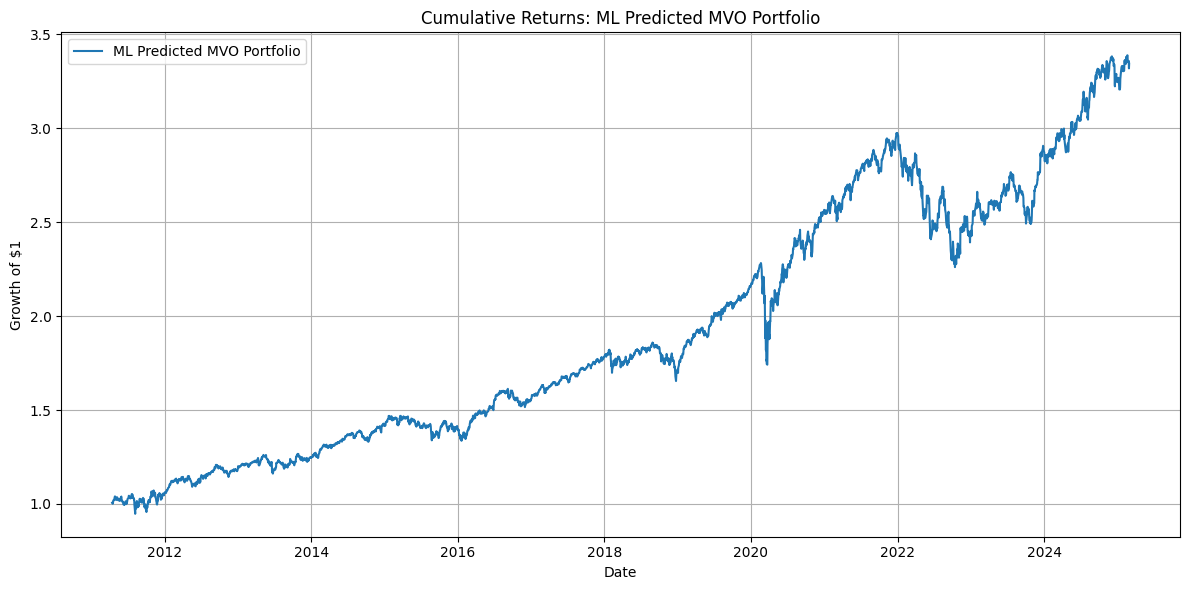

In [19]:
# =========================
# Machine Learning Expected Returns Prediction (Random Forest)
# =========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.objective_functions import L2_reg
import matplotlib.pyplot as plt

print("\n=== Machine Learning Expected Returns Prediction (Random Forest) ===")

#Feature Engineering
def create_features(prices, window_short=5, window_long=20):
    returns = prices.pct_change().fillna(0)
    vol = returns.rolling(window=window_long).std().fillna(0)
    ma_short = prices.pct_change(periods=window_short).fillna(0)
    ma_long = prices.pct_change(periods=window_long).fillna(0)

    features = pd.concat([
        returns.add_suffix('_ret'),
        vol.add_suffix('_vol'),
        ma_short.add_suffix(f'_ma{window_short}'),
        ma_long.add_suffix(f'_ma{window_long}')
    ], axis=1)

    return features

# Generate features
features = create_features(prices)

# Align features and target future returns
future_returns = prices.pct_change().shift(-1)  # 1-day ahead returns
features = features.shift(1)  # Lag features to avoid lookahead bias

# Align on same dates
features = features.loc[future_returns.index]
features = features.dropna()
future_returns = future_returns.loc[features.index]

#Random Forest Training and Prediction
predicted_mu = pd.DataFrame(index=features.index, columns=prices.columns)

for asset in prices.columns:
    print(f"Training Random Forest model for {asset}...")
    X = features[[col for col in features.columns if col.startswith(asset)]].dropna()
    y = future_returns[asset].loc[X.index]

    # Standardize features (optional, good practice)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)

    preds = pd.Series(index=X.index, dtype=float)

    for train_idx, test_idx in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, _ = y.iloc[train_idx], y.iloc[test_idx]

        rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
        rf.fit(X_train, y_train)

        preds.iloc[test_idx] = rf.predict(X_test)

    predicted_mu[asset] = preds

# Drop any remaining missing dates
predicted_mu = predicted_mu.dropna()

print("\nSample of Predicted Expected Returns (μ):")
print(predicted_mu.head())

#Optimization Using ML Predicted μ

print("\n=== Portfolio Optimization Using ML Predicted Expected Returns ===")

# Align prices to predicted_mu dates
aligned_prices = prices.loc[predicted_mu.index]
aligned_daily_returns = aligned_prices.pct_change().dropna()

# Covariance matrix estimation (Ledoit-Wolf shrinkage)
cov_matrix_ml = CovarianceShrinkage(aligned_prices).ledoit_wolf()

# Mean returns from Random Forest predictions
mean_returns_ml = predicted_mu.loc[aligned_daily_returns.index].mean()

# Risk-free rate for the aligned period (fixed version!)
rf_ml_mean = float(rf_daily.loc[aligned_daily_returns.index].mean())

# Setup and solve optimization
ef = EfficientFrontier(mean_returns_ml, cov_matrix_ml)
ef.add_objective(L2_reg, gamma=0.1)  # Optional L2 regularization
ef.max_sharpe(risk_free_rate=rf_ml_mean)

# Extract optimized weights
weights_ml = pd.Series(ef.clean_weights(), name='Weights_ML')

print("\n--- Final Machine Learning Optimized Weights ---")
print(weights_ml.round(4))

# 4. Portfolio Performance

# Calculate daily returns
portfolio_returns_ml = aligned_daily_returns @ weights_ml
cumulative_ml = (1 + portfolio_returns_ml).cumprod()

# Save metrics
m_ml, c_ml = compute_metrics(portfolio_returns_ml, "ML Predicted MVO")
metrics["ML Predicted MVO"] = m_ml
curves["ML Predicted MVO"] = cumulative_ml

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(cumulative_ml, label="ML Predicted MVO Portfolio")
plt.title("Cumulative Returns: ML Predicted MVO Portfolio")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# =========================
# Machine Learning Expected Returns Prediction (Random Forest) with Rolling Rebalancing
# =========================

print("\n=== Rolling Rebalancing: ML Predicted MVO ===")

rolling_start_idx = 0
window_train = 252 * 5  # 5 years training
window_test = 252       # 1 year testing
ml_rolling_returns = []

dates = daily_returns.index

while rolling_start_idx + window_train + window_test <= len(dates):
    # Define train and test periods
    train_period = dates[rolling_start_idx : rolling_start_idx + window_train]
    test_period = dates[rolling_start_idx + window_train : rolling_start_idx + window_train + window_test]

    # Prepare rolling data
    train_prices_roll = prices.loc[train_period]
    test_prices_roll = prices.loc[test_period]
    train_returns_roll = train_prices_roll.pct_change().dropna()
    test_returns_roll = test_prices_roll.pct_change().dropna()

    # --- Feature Engineering for rolling window ---
    features_roll = create_features(train_prices_roll)

    # Align features and target
    future_returns_roll = train_prices_roll.pct_change().shift(-1)
    features_roll = features_roll.shift(1)  # Lag features
    features_roll = features_roll.loc[future_returns_roll.index]
    features_roll = features_roll.dropna()
    future_returns_roll = future_returns_roll.loc[features_roll.index]

    # --- Random Forest Training for rolling window ---
    predicted_mu_roll = pd.DataFrame(index=features_roll.index, columns=train_prices_roll.columns)

    for asset in train_prices_roll.columns:
        X = features_roll[[col for col in features_roll.columns if col.startswith(asset)]].dropna()
        y = future_returns_roll[asset].loc[X.index]

        # Standardize
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Time Series Cross-Validation
        tscv = TimeSeriesSplit(n_splits=5)

        preds = pd.Series(index=X.index, dtype=float)

        for train_idx, test_idx in tscv.split(X_scaled):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, _ = y.iloc[train_idx], y.iloc[test_idx]

            rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
            rf.fit(X_train, y_train)

            preds.iloc[test_idx] = rf.predict(X_test)

        predicted_mu_roll[asset] = preds

    predicted_mu_roll = predicted_mu_roll.dropna()

    # --- Optimization using predicted μ ---
    aligned_prices_roll = train_prices_roll.loc[predicted_mu_roll.index]
    aligned_daily_returns_roll = aligned_prices_roll.pct_change().dropna()

    cov_matrix_ml_roll = CovarianceShrinkage(aligned_prices_roll).ledoit_wolf()
    mean_returns_ml_roll = predicted_mu_roll.loc[aligned_daily_returns_roll.index].mean()
    rf_ml_mean_roll = float(rf_daily.loc[aligned_daily_returns_roll.index].mean())

    ef = EfficientFrontier(mean_returns_ml_roll, cov_matrix_ml_roll)
    ef.add_objective(L2_reg, gamma=0.1)
    ef.max_sharpe(risk_free_rate=rf_ml_mean_roll)

    weights_ml_roll = pd.Series(ef.clean_weights(), index=aligned_prices_roll.columns)

    # --- Out-of-sample test performance ---
    test_returns_roll = test_prices_roll.pct_change().dropna()
    port_returns_test = test_returns_roll @ weights_ml_roll
    ml_rolling_returns.append(port_returns_test)

    rolling_start_idx += window_test  # Move window forward

# Concatenate all rolling returns
ml_rolling_returns = pd.concat(ml_rolling_returns)

# Save cumulative returns for rolling model
curves["ML Predicted MVO (Rolling)"] = (1 + ml_rolling_returns).cumprod()


=== Rolling Rebalancing: ML Predicted MVO ===


In [22]:
# --- Add Rolling Twin Model Metrics ---

# Strict-Factor MVO (Rolling)
returns_strict_rolling = strict_rolling_returns  # should already be defined
m_strict_rolling, c_strict_rolling = compute_metrics(returns_strict_rolling, "Strict-Factor MVO (Rolling)")
metrics["Strict-Factor MVO (Rolling)"] = m_strict_rolling
curves["Strict-Factor MVO (Rolling)"] = (1 + returns_strict_rolling).cumprod()

# ML Predicted MVO (Rolling)
returns_ml_rolling = ml_rolling_returns  # should already be defined
m_ml_rolling, c_ml_rolling = compute_metrics(returns_ml_rolling, "ML Predicted MVO (Rolling)")
metrics["ML Predicted MVO (Rolling)"] = m_ml_rolling
curves["ML Predicted MVO (Rolling)"] = (1 + returns_ml_rolling).cumprod()

In [23]:
# Combine and Display Final Metrics (Updated for Rolling Models)


# Models Only (static + rolling models)
model_metrics = {k: v for k, v in metrics.items() if k not in etf_metrics}
oos_table = pd.concat(model_metrics.values(), axis=1).round(6)

# Individual ETFs
etf_table = pd.concat(etf_metrics.values(), axis=1).round(6)

# Full Combined Table (Models + ETFs)
metrics_table = pd.concat(list(model_metrics.values()) + list(etf_metrics.values()), axis=1).round(6)

print("\n--- Final Out-of-Sample Model Comparison Table (Static + Rolling Models) ---")
display(oos_table)

print("\n--- Individual ETF Benchmark Performance ---")
display(etf_table)

print("\n--- Full Metrics Table: Models + ETFs ---")
display(metrics_table)


--- Final Out-of-Sample Model Comparison Table (Static + Rolling Models) ---


,MVO-LW (Static),Equal-Weighted,MVO-Naive,LW Subset,RMT Relaxed (1.2) - Gamma 0.1,RMT Base (1.0) - Gamma 0.1,RMT High (1.4) - Gamma 0.1,Strict-Factor MVO,Expected Utility Optimized,ML Predicted MVO,Strict-Factor MVO (Rolling),ML Predicted MVO (Rolling)
Mean Return,0.000384,0.000292,0.00022,0.000326,0.000639,0.000639,0.000639,0.001012,0.000727,0.000372,0.000843,0.000414
Annual Return,0.096755,0.07371,0.055334,0.082146,0.161019,0.161023,0.161016,0.255066,0.18321,0.093753,0.212434,0.10435
Geometric Return,0.095451,0.067255,0.055868,0.080015,0.152833,0.152836,0.15283,0.245675,0.165307,0.091088,0.206776,0.098646
Min Return,-0.060352,-0.075298,-0.034258,-0.059306,-0.113185,-0.11319,-0.113181,-0.13814,-0.147002,-0.080701,-0.13814,-0.089471
Max Drawdown (%),-23.158227,-32.633029,-7.089279,-23.508,-30.873408,-30.874458,-30.872472,-33.559077,-46.700015,-24.000707,-33.589076,-26.498282
Max 10-Day Drawdown (%),-15.298765,-22.892121,-5.597748,-18.304772,-24.793002,-24.793639,-24.792462,-22.263673,-27.676143,-21.43977,-22.263673,-21.085957
Sharpe Ratio,Ticker ^IRX 0.807759 dtype: float64,Ticker ^IRX 0.474592 dtype: float64,Ticker ^IRX 0.998811 dtype: float64,Ticker ^IRX 0.695907 dtype: float64,Ticker ^IRX 0.706855 dtype: float64,Ticker ^IRX 0.706854 dtype: float64,Ticker ^IRX 0.706856 dtype: float64,Ticker ^IRX 0.869085 dtype: float64,Ticker ^IRX 0.699327 dtype: float64,Ticker ^IRX 0.703591 dtype: float64,Ticker ^IRX 0.899202 dtype: float64,Ticker ^IRX 0.632366 dtype: float64
Volatility,0.105585,0.131147,0.043918,0.101561,0.193246,0.193251,0.193241,0.265386,0.245581,0.114413,0.220726,0.142945
Skewness,-0.017311,-0.236985,-0.307364,-0.131628,-0.588661,-0.588683,-0.588644,-0.218798,-0.030188,-0.604229,-0.224766,-0.641644
Kurtosis,12.569031,15.128447,20.375239,12.742815,11.633497,11.633844,11.633226,7.520349,9.552486,14.351289,9.80011,11.037228



--- Individual ETF Benchmark Performance ---


,AGG,DBC,EEM,EFA,GLD,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000117,-0.000065,0.000231,0.000257,0.000307,0.000232,0.000451,0.000185,0.000519,0.000164,0.000113,0.00046,0.000385,0.00032,0.00071
Annual Return,0.02958,-0.016305,0.058115,0.064776,0.077353,0.058536,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.028451,-0.034136,0.019438,0.041099,0.064786,0.053476,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.068395,-0.079444,-0.161662,-0.111632,-0.087808,-0.080975,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195137,-0.12138,-0.201412,-0.13814
Max Drawdown (%),-18.432931,-76.362638,-58.678427,-52.789198,-45.555013,-30.359638,-53.884055,-24.954897,-47.165231,-48.351132,-22.190942,-66.125042,-49.757513,-71.262765,-44.22569
Max 10-Day Drawdown (%),-10.339747,-24.596081,-41.000793,-32.881844,-23.386499,-21.699205,-38.910067,-23.172121,-30.114939,-11.063218,-9.649854,-38.630246,-31.489331,-60.487765,-25.918938
Sharpe Ratio,Ticker ^IRX 0.328814 dtype: float64,Ticker ^IRX -0.144965 dtype: float64,Ticker ^IRX 0.166896 dtype: float64,Ticker ^IRX 0.241009 dtype: float64,Ticker ^IRX 0.386063 dtype: float64,Ticker ^IRX 0.414258 dtype: float64,Ticker ^IRX 0.40806 dtype: float64,Ticker ^IRX 0.385914 dtype: float64,Ticker ^IRX 0.598895 dtype: float64,Ticker ^IRX 0.190941 dtype: float64,Ticker ^IRX 0.212744 dtype: float64,Ticker ^IRX 0.344664 dtype: float64,Ticker ^IRX 0.411732 dtype: float64,Ticker ^IRX 0.224137 dtype: float64,Ticker ^IRX 0.721479 dtype: float64
Volatility,0.05508,0.19159,0.279496,0.221186,0.170658,0.113618,0.250479,0.091272,0.199219,0.156517,0.080355,0.303209,0.207953,0.308059,0.23213
Skewness,-2.010049,-0.44381,0.686138,-0.03293,-0.08503,0.764488,-0.379368,0.053288,-0.082267,0.096349,-0.018816,-0.021186,-0.344438,-0.273788,-0.015035
Kurtosis,52.366519,3.618409,21.604119,14.388529,7.459103,41.65358,6.467457,57.593739,14.683862,3.131749,3.642587,17.283121,12.813004,12.761121,9.376909



--- Full Metrics Table: Models + ETFs ---


,MVO-LW (Static),Equal-Weighted,MVO-Naive,LW Subset,RMT Relaxed (1.2) - Gamma 0.1,RMT Base (1.0) - Gamma 0.1,RMT High (1.4) - Gamma 0.1,Strict-Factor MVO,Expected Utility Optimized,ML Predicted MVO,...,HYG,IWM,LQD,SPY,TLT,UUP,VNQ,VT,XLE,XLK
Mean Return,0.000384,0.000292,0.00022,0.000326,0.000639,0.000639,0.000639,0.001012,0.000727,0.000372,...,0.000232,0.000451,0.000185,0.000519,0.000164,0.000113,0.00046,0.000385,0.00032,0.00071
Annual Return,0.096755,0.07371,0.055334,0.082146,0.161019,0.161023,0.161016,0.255066,0.18321,0.093753,...,0.058536,0.113679,0.046692,0.130779,0.041354,0.028563,0.115973,0.097089,0.080516,0.178945
Geometric Return,0.095451,0.067255,0.055868,0.080015,0.152833,0.152836,0.15283,0.245675,0.165307,0.091088,...,0.053476,0.085625,0.043438,0.117267,0.029541,0.025658,0.072344,0.078289,0.033324,0.164096
Min Return,-0.060352,-0.075298,-0.034258,-0.059306,-0.113185,-0.11319,-0.113181,-0.13814,-0.147002,-0.080701,...,-0.080975,-0.132669,-0.091111,-0.109424,-0.066683,-0.032196,-0.195137,-0.12138,-0.201412,-0.13814
Max Drawdown (%),-23.158227,-32.633029,-7.089279,-23.508,-30.873408,-30.874458,-30.872472,-33.559077,-46.700015,-24.000707,...,-30.359638,-53.884055,-24.954897,-47.165231,-48.351132,-22.190942,-66.125042,-49.757513,-71.262765,-44.22569
Max 10-Day Drawdown (%),-15.298765,-22.892121,-5.597748,-18.304772,-24.793002,-24.793639,-24.792462,-22.263673,-27.676143,-21.43977,...,-21.699205,-38.910067,-23.172121,-30.114939,-11.063218,-9.649854,-38.630246,-31.489331,-60.487765,-25.918938
Sharpe Ratio,Ticker ^IRX 0.807759 dtype: float64,Ticker ^IRX 0.474592 dtype: float64,Ticker ^IRX 0.998811 dtype: float64,Ticker ^IRX 0.695907 dtype: float64,Ticker ^IRX 0.706855 dtype: float64,Ticker ^IRX 0.706854 dtype: float64,Ticker ^IRX 0.706856 dtype: float64,Ticker ^IRX 0.869085 dtype: float64,Ticker ^IRX 0.699327 dtype: float64,Ticker ^IRX 0.703591 dtype: float64,...,Ticker ^IRX 0.414258 dtype: float64,Ticker ^IRX 0.40806 dtype: float64,Ticker ^IRX 0.385914 dtype: float64,Ticker ^IRX 0.598895 dtype: float64,Ticker ^IRX 0.190941 dtype: float64,Ticker ^IRX 0.212744 dtype: float64,Ticker ^IRX 0.344664 dtype: float64,Ticker ^IRX 0.411732 dtype: float64,Ticker ^IRX 0.224137 dtype: float64,Ticker ^IRX 0.721479 dtype: float64
Volatility,0.105585,0.131147,0.043918,0.101561,0.193246,0.193251,0.193241,0.265386,0.245581,0.114413,...,0.113618,0.250479,0.091272,0.199219,0.156517,0.080355,0.303209,0.207953,0.308059,0.23213
Skewness,-0.017311,-0.236985,-0.307364,-0.131628,-0.588661,-0.588683,-0.588644,-0.218798,-0.030188,-0.604229,...,0.764488,-0.379368,0.053288,-0.082267,0.096349,-0.018816,-0.021186,-0.344438,-0.273788,-0.015035
Kurtosis,12.569031,15.128447,20.375239,12.742815,11.633497,11.633844,11.633226,7.520349,9.552486,14.351289,...,41.65358,6.467457,57.593739,14.683862,3.131749,3.642587,17.283121,12.813004,12.761121,9.376909


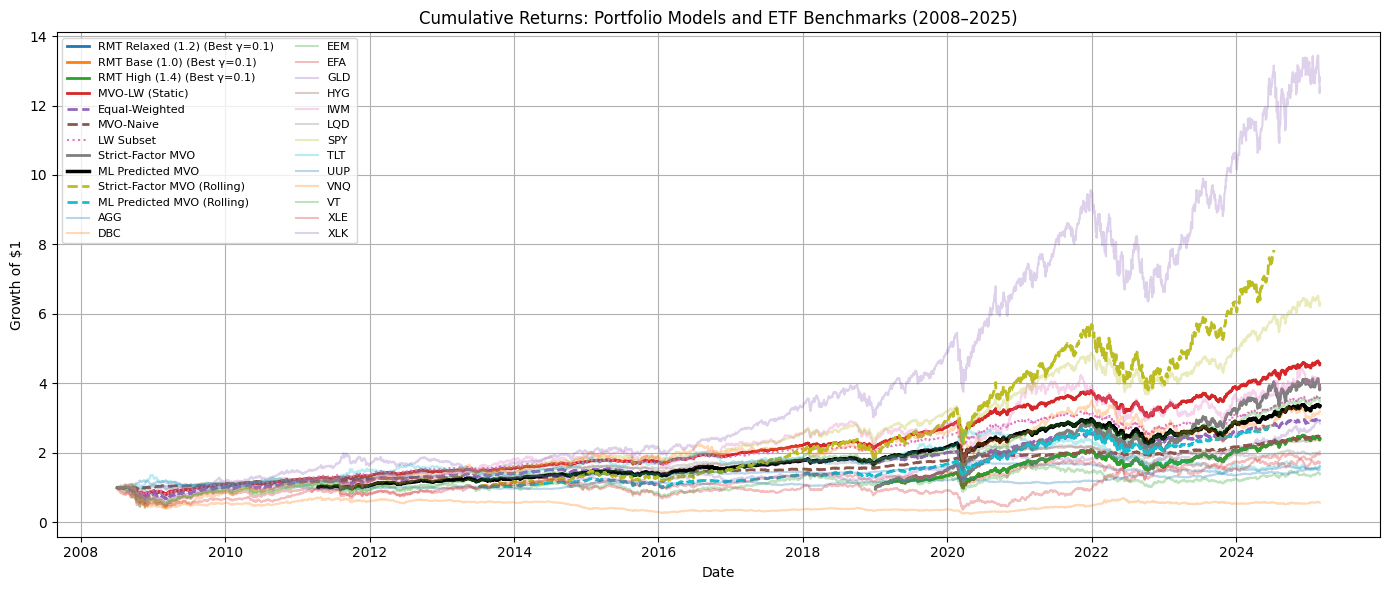

In [24]:
# Cumulative Returns Plot

plt.figure(figsize=(14, 6))

# Dynamically add all Best Gamma RMT models
for label in curves:
    if "RMT" in label and "Best γ=" in label:
        plt.plot(curves[label], label=label, linewidth=2)

# Static Models
plt.plot(curves["MVO-LW (Static)"], label="MVO-LW (Static)", linewidth=2)
plt.plot(curves["Equal-Weighted"], label="Equal-Weighted", linewidth=2, linestyle="--")
plt.plot(curves["MVO-Naive"], label="MVO-Naive", linestyle="--", linewidth=2)
plt.plot(curves["LW Subset"], label="LW Subset", linestyle=":")
plt.plot(curves["Strict-Factor MVO"], label="Strict-Factor MVO", linewidth=2)
plt.plot(curves["ML Predicted MVO"], label="ML Predicted MVO", color='black', linewidth=2.5)

# Rolling Twin Models
plt.plot(curves["Strict-Factor MVO (Rolling)"], label="Strict-Factor MVO (Rolling)", linestyle="--", linewidth=2)
plt.plot(curves["ML Predicted MVO (Rolling)"], label="ML Predicted MVO (Rolling)", linestyle="--", linewidth=2)

# ETF Benchmarks (lighter lines)
for ticker, curve in etf_curves.items():
    plt.plot(curve, label=ticker, alpha=0.3)

plt.title("Cumulative Returns: Portfolio Models and ETF Benchmarks (2008–2025)")
plt.ylabel("Growth of $1")
plt.xlabel("Date")
plt.legend(fontsize=8, loc="upper left", ncol=2)
plt.grid(True)
plt.tight_layout()

# Save plot
plt.savefig("cumulative_returns_plot.png", dpi=300)
plt.show()

In [25]:
print("\n--- Final Weights for Best-Gamma RMT Portfolios ---")

for relax, label in zip([1.2, 1.0, 1.4], ["RMT Relaxed (1.2)", "RMT Base (1.0)", "RMT High (1.4)"]):
    gamma_data = rmt_gamma_metrics[label]
    best_gamma = max(gamma_data.items(), key=lambda x: x[1][0]["Sharpe Ratio"].item())[0]

    # Rebuild training data
    train_start, train_end = "2008-07-01", "2018-12-31"
    train_prices = prices.loc[train_start:train_end]
    train_returns = train_prices.pct_change().dropna()
    mu_train = mean_historical_return(train_prices, frequency=252)
    rf_train_mean = float(rf_daily.loc[train_returns.index].mean())

    # Get covariance matrix and weights for best gamma
    cov = rmt_denoised_covariance(train_returns, relax=relax, label=label)
    ef = EfficientFrontier(mu_train, cov)
    ef.add_objective(L2_reg, gamma=best_gamma)
    ef.max_sharpe(risk_free_rate=rf_train_mean)
    weights = pd.Series(ef.clean_weights()).sort_values(ascending=False).round(4)

    print(f"\nFinal Weights ({label}, Best γ={best_gamma}):")
    print(weights)


--- Final Weights for Best-Gamma RMT Portfolios ---
[RMT Relaxed (1.2)] λ₊ = 0.0002 — Clipped 1 eigenvalue(s)

Final Weights (RMT Relaxed (1.2), Best γ=0.1):
XLK    0.1762
SPY    0.1304
IWM    0.1201
VNQ    0.1034
TLT    0.0879
HYG    0.0823
LQD    0.0771
VT     0.0747
AGG    0.0541
GLD    0.0385
EFA    0.0235
UUP    0.0204
EEM    0.0114
DBC    0.0000
XLE    0.0000
dtype: float64
[RMT Base (1.0)] λ₊ = 0.0002 — Clipped 2 eigenvalue(s)

Final Weights (RMT Base (1.0), Best γ=0.1):
XLK    0.1762
SPY    0.1304
IWM    0.1201
VNQ    0.1034
TLT    0.0878
HYG    0.0823
LQD    0.0771
VT     0.0747
AGG    0.0541
GLD    0.0385
EFA    0.0235
UUP    0.0203
EEM    0.0114
DBC    0.0000
XLE    0.0000
dtype: float64
[RMT High (1.4)] λ₊ = 0.0003 — Clipped 1 eigenvalue(s)

Final Weights (RMT High (1.4), Best γ=0.1):
XLK    0.1763
SPY    0.1304
IWM    0.1201
VNQ    0.1033
TLT    0.0879
HYG    0.0823
LQD    0.0772
VT     0.0747
AGG    0.0541
GLD    0.0386
EFA    0.0235
UUP    0.0204
EEM    0.0114
DBC    0.

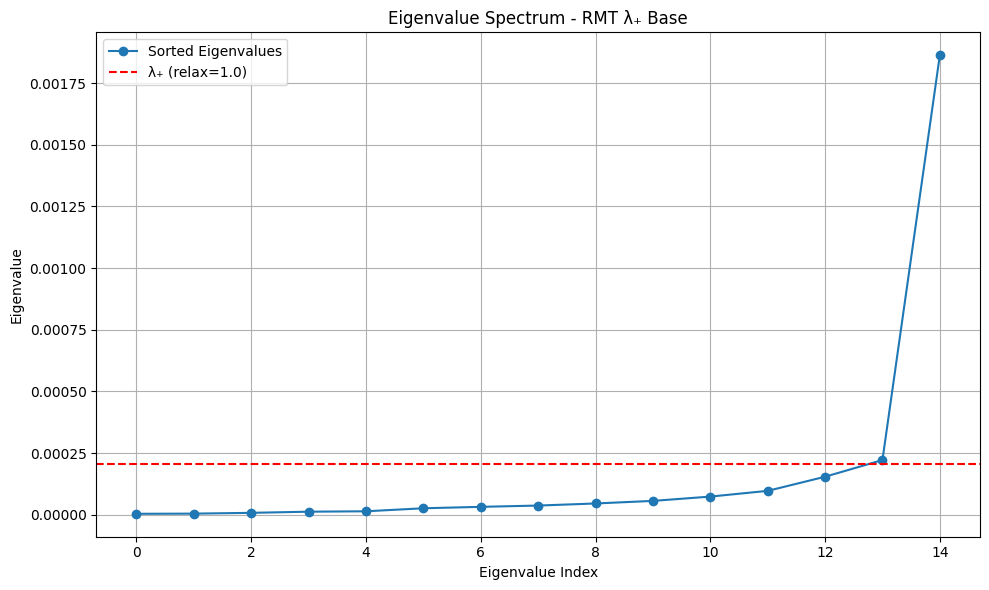

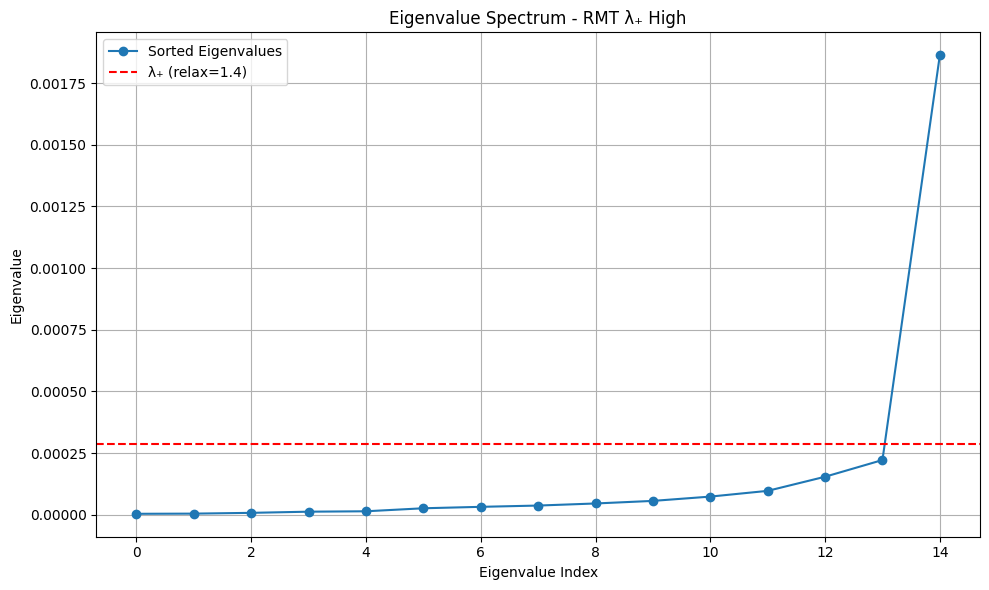

In [26]:
# --- Eigenvalue Spectrum Diagnostic Plot ---
import matplotlib.pyplot as plt
import numpy as np

def plot_eigenvalue_spectrum(returns, relax=1.0, label=""):
    """
    Plot the sorted eigenvalues of the sample covariance matrix,
    along with the Marčenko–Pastur λ₊ threshold.
    """
    T, N = returns.shape
    sample_cov = np.cov(returns, rowvar=False)
    eigenvals = np.sort(np.linalg.eigvalsh(sample_cov))  # sorted ascending

    # Calculate Marčenko–Pastur threshold
    q = T / N
    lambda_plus = (sample_cov.trace() / N) * (1 + 1 / np.sqrt(q))**2 * relax

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(eigenvals, marker='o', label='Sorted Eigenvalues')
    plt.axhline(y=lambda_plus, color='red', linestyle='--', label=f'λ₊ (relax={relax})')
    plt.title(f"Eigenvalue Spectrum - {label}")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"eigenvalue_spectrum_{label.replace(' ', '_').replace('λ₊', 'lambda')}.png", dpi=300)
    plt.show()

# Use training set from last regime to ensure consistency
last_train_start, last_train_end, _, _ = regimes[-1]
last_train_prices = prices.loc[last_train_start:last_train_end]
last_train_returns = last_train_prices.pct_change().dropna()

# Plot for RMT λ₊ Base and High
plot_eigenvalue_spectrum(last_train_returns, relax=1.0, label="RMT λ₊ Base")
plot_eigenvalue_spectrum(last_train_returns, relax=1.4, label="RMT λ₊ High")

In [27]:
import numpy as np

# Calculate sample covariance and eigenvalues again to be safe
sample_cov = np.cov(daily_returns, rowvar=False)
sample_eigenvals = np.linalg.eigvalsh(sample_cov)

total_variance = np.sum(sample_eigenvals)
top5_variance = np.sum(sorted(sample_eigenvals, reverse=True)[:5])

print("\n--- Variance Concentration Diagnostics ---")
print(f"Total Variance: {total_variance:.4f}")
print(f"Variance explained by Top 5 Eigenvalues: {top5_variance:.4f}")
print(f"Percentage explained by Top 5: {100 * top5_variance / total_variance:.2f}%")


--- Variance Concentration Diagnostics ---
Total Variance: 0.0025
Variance explained by Top 5 Eigenvalues: 0.0023
Percentage explained by Top 5: 89.76%


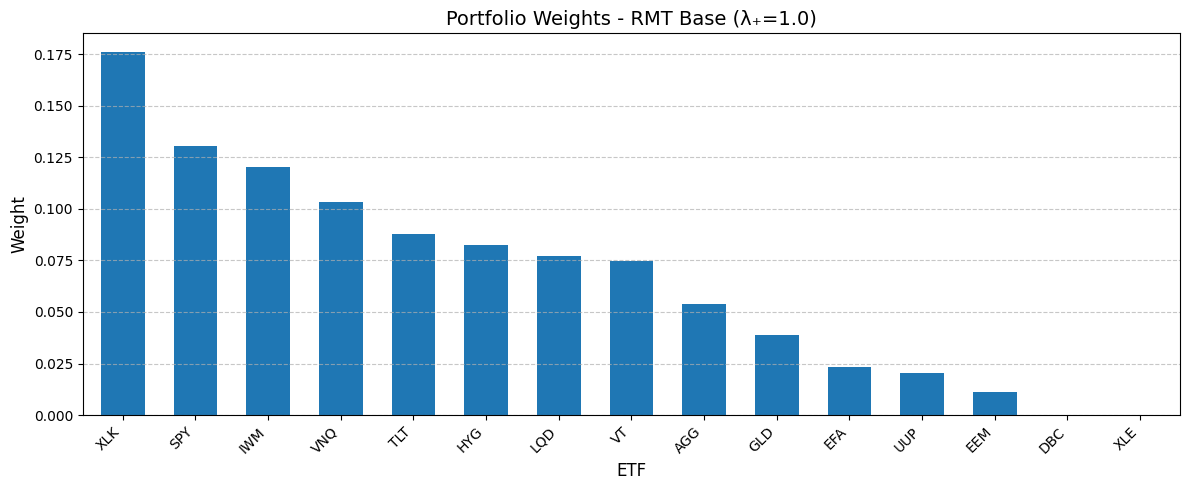

In [28]:
import matplotlib.pyplot as plt

# Create the bar chart
plt.figure(figsize=(12, 5))
weights.plot(kind='bar', width=0.6)
plt.title('Portfolio Weights - RMT Base (λ₊=1.0)', fontsize=14)
plt.ylabel('Weight', fontsize=12)
plt.xlabel('ETF', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('rmt_base_weights_.png', dpi=300)

plt.show()

In [29]:
cumulative_returns_df = pd.DataFrame(curves)
cumulative_returns_df.to_csv("MVO_Cumulative_Returns_.csv")
print("Saved: MVO_Cumulative_Returns_.csv")

Saved: MVO_Cumulative_Returns_.csv


In [30]:
oos_table.to_csv("MVO_Final_Metrics_Table_.csv")
print("Saved: MVO_Final_Metrics_Table_.csv")

Saved: MVO_Final_Metrics_Table_.csv


In [31]:
prices.to_csv("MVO_Prices_.csv")
print("Saved: MVO_Prices_.csv")

Saved: MVO_Prices_.csv


In [32]:
# Save Gamma Sweep Curves
gamma_curves = {}

for relax_label, gamma_data in rmt_gamma_metrics.items():
    for gamma, (_, curve) in gamma_data.items():
        label = f"{relax_label} - Gamma {gamma}"
        gamma_curves[label] = curve

gamma_curves_df = pd.DataFrame(gamma_curves)
gamma_curves_df.to_csv("MVO_Gamma_Sweep_Returns.csv")
print("Saved: MVO_Gamma_Sweep_Returns.csv")

Saved: MVO_Gamma_Sweep_Returns.csv


In [33]:
# Save Variance Explained Results
variance_results = {
    "Total Variance": total_variance,
    "Top 5 Eigenvalues Variance": top5_variance,
    "Top 5 Variance %": 100 * top5_variance / total_variance
}

variance_df = pd.DataFrame.from_dict(variance_results, orient="index", columns=["Value"])
variance_df.to_csv("MVO_Variance_Concentration_.csv")
print("Saved: MVO_Variance_Concentration_.csv")

Saved: MVO_Variance_Concentration_.csv
